In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Circle
import numpy as np
import torch as pt
import torch.nn as nn
from physics import *           # V_step(), angel_diff(), to_tensor(), to_lambda()
from multi_optimizer import *   # multi_loss_fun(), get_time_forcing(), compute_multi_path_autograd(), optimizeMultiPath()
from multi_plotter import *     # cat_ts(), cat_F(), color_map(), plot_multi_traj(), plot_multi_forcing()

In [2]:
def circle_loss(traj, c, r):
    if isinstance(traj, list):
        tensor_traj = pt.stack(traj)
    n_points = tensor_traj.shape[0]
    dist = r - pt.norm(tensor_traj[:,0:2]-c, dim=1)
    circle_pen = pt.exp(5*pt.max(pt.zeros(n_points), dist)) - 1
    return circle_pen

In [3]:
def optimizeMultiObstaclePath(v0, target, F_logits, checkpoint_2d=None, checkpoint_dof=None, center=None, radius=None,
                              iters=500, fine_tuning_steps=50, plot_freq=50,
                              lr=9e-2, l2_rate=-1e0, time_rate=2e-8, reverse_rate=0.5, show_logs=True
    ):
    """
    Iteratively performs GD to optimize forcings
    
    v0: starting tensor in 6d (v0[5]=0)
    checkpoint_2d: num_checkpoints x 2 tensor containing fixed points in 2d
    target: ending tensor in 5d
    checkpoint_dof: num_checkpoints x 3 tensor containing learnable dfs at start of segments
    F_logits: list (length = number of checkpoints + 1)
                each element is a n_steps x 3 tensor of forcing terms
    center: center of circular obstacle
    radius: redius of circular obstacle
    """
    lr = to_lambda(lr)
    l2_rate = to_lambda(l2_rate)
    time_rate = to_lambda(time_rate)
    reverse_rate = to_lambda(reverse_rate)

    n_segments = checkpoint_2d.shape[0] + 1 if checkpoint_2d is not None else 1
    n_intermediate_segments = n_segments - 2
    num_logs = iters//plot_freq if iters%plot_freq == 0 else iters//plot_freq + 1

    optim = pt.optim.Adam(F_logits + [checkpoint_dof]) if checkpoint_dof is not None else pt.optim.Adam(F_logits)

    V_mat = []
    ts_mat = []
    F_true = []
    loss_logs = pt.zeros((num_logs, n_segments, 5)) # pos, time, l2, reverse, obstacle

    for i in range(iters):
        is_log_step = (i % plot_freq == plot_freq - 1) or (i== iters - 1)
        log_idx = i // plot_freq
        
        if is_log_step:
            # log v, ts, and F on current iteration's path
            v_path = []
            ts_path = []
            F_true_path = []

        loss = 0
        x = i / (iters - fine_tuning_steps)

        # compute first segment
        optim.zero_grad()

        end = pt.cat([checkpoint_2d[0], checkpoint_dof[0], pt.zeros(1, device=v0.device)], dim=0) if checkpoint_dof is not None else target
        traj, (position_loss, time_loss, l2_loss) = compute_multi_path_autograd(v0, F_logits[0], end)

        # compute loss
        l2_coef = l2_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
        time_coef = time_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
        reverse_coef = reverse_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
        obstacle_coef = 3
                
        reverse_loss = pt.mean(pt.exp(-5 * pt.stack(traj)[:,3]))
        obstacle_loss = 0 if center is None else pt.sum(circle_loss(traj, center, radius))


        if is_log_step:
            v_segment, ts_segment = to_tensor(traj)
            v_path.append(v_segment)
            ts_path.append(ts_segment)
            F_true_path.append(get_time_forcing(traj[:-1], F_logits[0][:, :]))
            loss_logs[log_idx,0,:] =  pt.tensor([position_loss, time_loss, l2_loss, reverse_loss, obstacle_loss])

        if n_segments == 1:
            loss += position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss + obstacle_coef*obstacle_loss
        else:
            loss += 3/2*position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss + obstacle_coef*obstacle_loss

        for j in range(n_intermediate_segments+1):
            start = end
            if j == n_segments-2:
                end = target
            else:
                end = pt.cat([checkpoint_2d[j+1], checkpoint_dof[j+1], pt.zeros(1, device=v0.device)], dim=0)

            traj, (position_loss, time_loss, l2_loss) = compute_multi_path_autograd(start, F_logits[j+1], end)

            reverse_loss = pt.mean(pt.exp(-5 * pt.stack(traj)[:,3]))
            obstacle_loss = 0 if center is None else pt.sum(circle_loss(traj, center, radius))


            if is_log_step:
                v_segment, ts_segment = to_tensor(traj)
                v_path.append(v_segment)
                ts_path.append(ts_segment)
                F_true_path.append(get_time_forcing(traj[:-1], F_logits[j+1][:, :]))
                loss_logs[log_idx,j+1,:] = pt.tensor([position_loss, time_loss, l2_loss, reverse_loss, obstacle_loss])

            if j == n_segments - 2:
                # no coefficient on position_loss because we don't need to enforce continuity as strictly at the end
                loss += position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss + obstacle_coef*obstacle_loss
            else:
                loss += 3/2*position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss + obstacle_coef*obstacle_loss

        if is_log_step:
            V_mat.append(v_path)
            ts_mat.append(ts_path)
            F_true.append(F_true_path)

        loss.backward()

        # set optimizer learning rate and take step
        step_lr = lr(x, position_loss)
        for param_group in optim.param_groups:
            param_group['lr'] = step_lr
        optim.step()


        # plot solution every plot_freq steps
        if show_logs and is_log_step:
            
            print(f'Iteration {i+1}, Mean Position Dist: {loss_logs[log_idx, :, 0].mean() ** 0.5:.3f},  '\
                  f'End Time: {loss_logs[log_idx,:,1].sum():.3f},  '\
                  f'L2: {loss_logs[log_idx,:,2].mean():.3f},  '\
                  f'Reverse Loss: {loss_logs[log_idx,:,3].mean():.3f},  '\
                  f'Obstacle Loss: {loss_logs[log_idx,:,4].sum():.3f}')
                   
    return F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs

In [4]:
# og path
v0 = v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

n_steps = pt.tensor([32])

dt_max = 0.25
t_final = n_steps.item()*dt_max

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

center = pt.tensor([2,2])

radius = 0.25

print(f'Start: {v0.detach()}\n' +
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiObstaclePath(v0, target, F_logits, center=center, radius=radius,
                                                                               reverse_rate=0,
                                                                               iters=1000)

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 1.223,  End Time: 5.311,  L2: 0.296,  Reverse Loss: 0.000,  Obstacle Loss: 0.000
Iteration 100, Mean Position Dist: 0.229,  End Time: 4.650,  L2: 0.263,  Reverse Loss: 0.001,  Obstacle Loss: 0.000
Iteration 150, Mean Position Dist: 0.134,  End Time: 4.726,  L2: 0.259,  Reverse Loss: 0.001,  Obstacle Loss: 0.000
Iteration 200, Mean Position Dist: 0.085,  End Time: 4.713,  L2: 0.264,  Reverse Loss: 0.000,  Obstacle Loss: 0.000
Iteration 250, Mean Position Dist: 0.065,  End Time: 4.719,  L2: 0.266,  Reverse Loss: 0.001,  Obstacle Loss: 0.000
Iteration 300, Mean Position Dist: 0.048,  End Time: 4.664,  L2: 0.285,  Reverse Loss: 0.000,  Obstacle Loss: 0.000
Iteration 350, Mean Position Dist: 0.385,  End Time: 4.637,  L2: 0.304,  Reverse Loss: 0.000,  Obstacle Loss: 0.000
Iteration 400, Mean Position Dist: 0.114,  End Time: 4.609,  L

In [5]:
def plot_multi_obstacle_traj(V_mat, target, checkpoint_2d=None, checkpoint_dof=None, dof_init=None, center=None, radius=None,
              ax=None, alphas=None, colors=None, cmap='viridis', vmin=0, vmax=1, figsize=(8,6)):
    """
    Plots trajectories of car on existing axes object or creates new one
    V_mat: list of lists (n_logs x n_segments)
           each sublist holds n_segments 5D tensors
           each 5D tensor holds position sequence of each segment for a given iteration
    target: target position in 5D space
    checkpoint_2d: tensor of 2D checkpoints (n_checkpoints x 2) (optional)
    checkpoint_dof: tensor of 3D checkpoint degrees of freedom theta, s omega (n_checkpoints x 3) (optional)
    dof_init: intitializations of checkpoint_dof (optional)
    """
    colors = color_map(len(V_mat[0]), cmap_name=cmap, vmin=vmin, vmax=vmax) if colors is None else colors
    if alphas is None:
        alphas = np.ones(len(V_mat))
        alphas[:-1] = np.linspace(0.1, 0.8, len(V_mat)-1)
        
    arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

    full_checkpoint = pt.cat([checkpoint_2d, checkpoint_dof], dim=1).detach() if checkpoint_2d is not None else None

    fig_exists = False

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True


    ax.scatter(*V_mat[0][0][0,0:2], marker='*', color='sandybrown', s=200, label='Start')
    ax.arrow(*V_mat[0][0][0,0:2], *arrowDir(V_mat[0][0][0,:]), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=6)

    if checkpoint_2d is not None:
        ax.scatter(checkpoint_2d[:,0], checkpoint_2d[:,1], marker='X', color='sandybrown', s=240, lw=0.8, label='Checkpoint')
    
    obstacle = Circle(center, radius, color='black', fill=True)
    ax.add_patch(obstacle)



    for i in range(len(V_mat)):
        lw = 2 if alphas[i] == 1 else 1.5
        # plot first segment
        ax.plot(V_mat[i][0][:,0], V_mat[i][0][:,1], lw=lw, color=colors[0], alpha=alphas[i], zorder=4)
        if i == len(V_mat)-1:
            if checkpoint_2d is not None:
                ax.scatter(*V_mat[i][0][-1,0:2], marker='x', color=colors[0], s=160, lw=2, zorder=6)
            ax.arrow(*V_mat[i][0][-1,0:2], *arrowDir(V_mat[i][0][-1,:]), head_width=0.1, head_length=0.1, lw=3, color=colors[0], alpha=alphas[i], zorder=6)

        # plot subsequent segments
        for j in range(len(V_mat[i])-1):
            ax.plot(V_mat[i][j+1][:,0], V_mat[i][j+1][:,1], lw=lw, color=colors[j+1], alpha=alphas[i], zorder=4)
            if i == len(V_mat)-1:
                if full_checkpoint is not None:
                    ax.arrow(*checkpoint_2d[j], *arrowDir(full_checkpoint[j]), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=5)
                if j != len(V_mat[i])-2:
                    ax.scatter(*V_mat[i][j+1][-1,0:2], marker='x', color=colors[j+1], s=160, lw=2, zorder=6)
                ax.arrow(*V_mat[i][j+1][-1,0:2], *arrowDir(V_mat[i][j+1][-1,:]), head_width=0.1, head_length=0.1, lw=3, color=colors[j+1], alpha=alphas[i], zorder=6)
                if dof_init is not None:
                    ax.arrow(*checkpoint_2d[j], dof_init[j,1]*np.cos(dof_init[j,0]), dof_init[j,1]*np.sin(dof_init[j,0]),
                             head_width=0.15, head_length=0.15, lw=4, color='black', zorder=5, label='Initial Guess')



    ax.scatter(*target[0:2],  marker='s', color='sandybrown', s=120, label='Target')
    ax.arrow(*target[0:2], *arrowDir(target), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=5)
    ax.scatter(*V_mat[-1][-1][-1,0:2], marker='D', color=colors[-1], s=120, label='End', zorder=6)
    ax.arrow(*V_mat[-1][-1][-1,0:2], *arrowDir(V_mat[-1][-1][-1,:]), head_width=0.1, head_length=0.1, lw=3, color=colors[-1], zorder=6)

    
    ax.set_aspect('equal')
    ax.legend()
    ax.set_title('Car Trajecotry')#, fontsize=16)
    ax.set_xlabel('X Position')#, fontsize=14)
    ax.set_ylabel('Y Position')#, fontsize=14)
    ax.grid()
    return (fig, ax) if fig_exists is True else ax

C:\Users\kenne\AppData\Local\Temp\ipykernel_24564\2252320362.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))


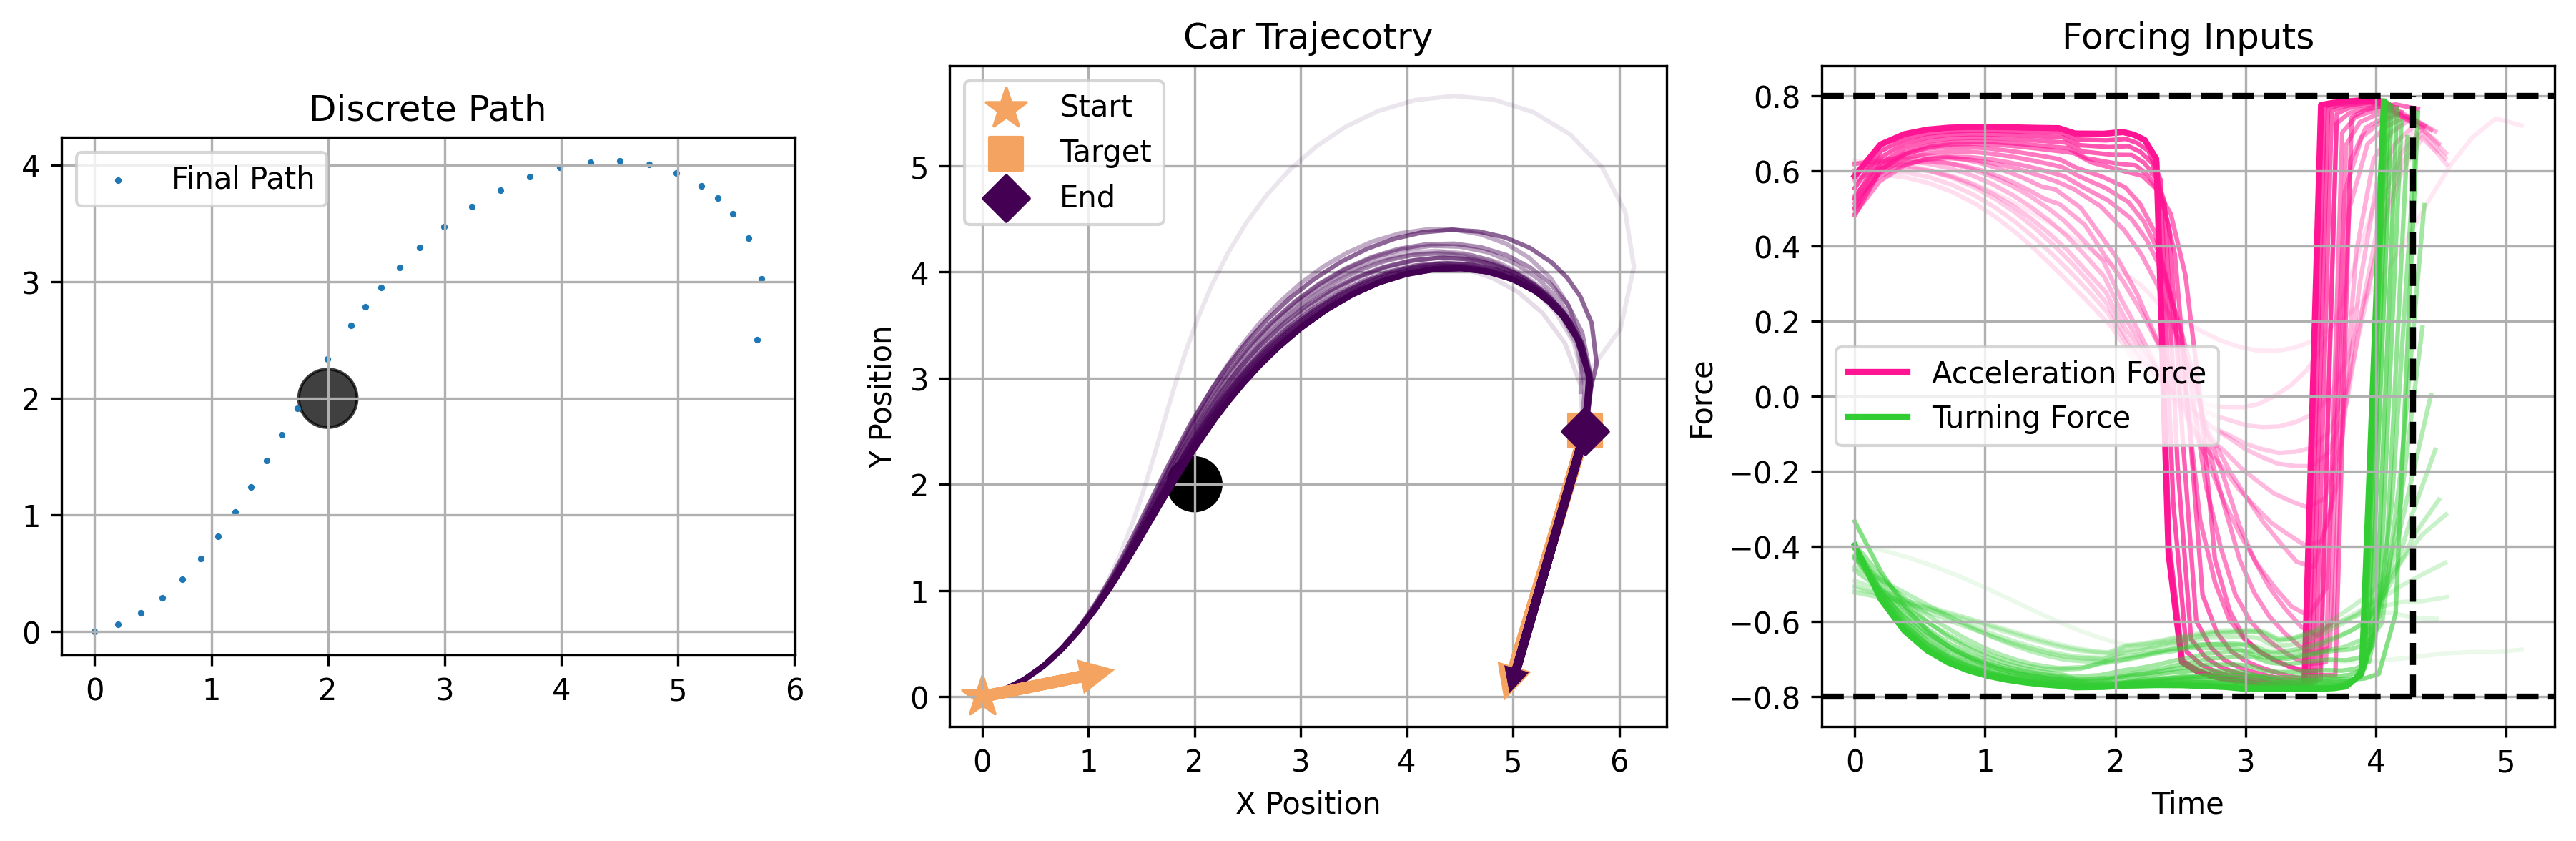

In [6]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

#fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12,16))
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), dpi=300)

circle = Circle(center, radius, color='k', alpha=0.75)

# Add the circle to the axes
ax1.add_patch(circle)

ax1.scatter(V_mat[-1][-1][:,0], V_mat[-1][-1][:,1], s=1.5, label='Final Path')
ax1.grid()
ax1.set_title('Discrete Path')
ax1.set_aspect('equal')
ax1.legend()

plot_multi_obstacle_traj(V_mat, target, center=center, radius=radius, ax=ax2)
plot_multi_forcing(F_cat, ts_cat, n_steps, ax=ax3)
plt.show()

The car is moving fast enough to pass through the obstacle between timesteps.